In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import symphonypy as sp
import palantir
import scib

sc.settings.verbosity = 0
#sc.settings.set_figure_params(dpi=80)
pd.set_option('display.max_columns', None)
seed = 10
np.random.seed(seed)
plt.rcParams["axes.titlesize"] = 11
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9
plt.rcParams["axes.linewidth"] = 0.75
plt.rcParams["legend.fontsize"] = 9
plt.rcParams["legend.fontsize"] = 9
plt.rcParams["font.size"] = 9

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Setup plotnine

In [2]:
from plotnine import ggplot, geom_point, aes, geom_smooth, facet_wrap, theme_bw,\
xlab, ylab, theme, element_text, element_blank, element_rect, geom_bin_2d, \
scale_fill_gradient, guide_colorbar

In [3]:
# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

In [6]:
import os
os.getcwd()

'/crex/proj/lappalainen_lab1/users/marii/d2n/d2n_ms/09-integration'

In [7]:
adata = sc.read_h5ad("../../data/09-integration/triana_et_al_healthy_young.h5ad")
adata

AnnData object with n_obs × n_vars = 13165 × 30539
    obs: 'Cluster_ID', 'donor_id', 'Cell_label', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'Genotype', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_bothtsne', 'X_bothumap', 'X_mofa', 'X_mofatsne', 'X_mofaumap', 'X_pca', 'X_projected', 'X_projectedmean'

In [8]:
adata.obs

Cluster_ID donor_id                  Cell_label  is_primary_data  \
884635         14      BM3   Late erythroid progenitor             True   
518328         14      BM3   Late erythroid progenitor             True   
392962         14      BM3   Late erythroid progenitor             True   
826846         14      BM3   Late erythroid progenitor             True   
97453          30      BM3   Late erythroid progenitor             True   
...           ...      ...                         ...              ...   
841282         22      BM3            Immature B cells             True   
564865          0      BM3        Mature naive B cells             True   
248583         11      BM3          CD4+ naive T cells             True   
675416          6      BM3       CD56dimCD16+ NK cells             True   
411265          4      BM3  Nonswitched memory B cells             True   

       organism_ontology_term_id self_reported_ethnicity_ontology_term_id  \
884635            NCBITaxon:9606                                  unknown   
518328            NCBITaxon:9606                                  unknown   
392962            NCBITaxon:9606                                  unknown   
826846            NCBITaxon:9606                                  unknown   
97453             NCBITaxon:9606                                  unknown   
...                          ...                                      ...   
841282            NCBITaxon:9606                                  unknown   
564865            NCBITaxon:9606                                  unknown   
248583            NCBITaxon:9606                                  unknown   
675416            NCBITaxon:9606                                  unknown   
411265            NCBITaxon:9606                                  unknown   

       assay_ontology_term_id tissue_ontology_term_id Genotype  \
884635            EFO:0700003          UBERON:0002371  healthy   
518328            EFO:0700003          UBERON:0002371  healthy   
392962            EFO:0700003          UBERON:0002371  healthy   
826846            EFO:0700003          UBERON:0002371  healthy   
97453             EFO:0700003          UBERON:0002371  healthy   
...                       ...                     ...      ...   
841282            EFO:0700003          UBERON:0002371  healthy   
564865            EFO:0700003          UBERON:0002371  healthy   
248583            EFO:0700003          UBERON:0002371  healthy   
675416            EFO:0700003          UBERON:0002371  healthy   
411265            EFO:0700003          UBERON:0002371  healthy   

       development_stage_ontology_term_id sex_ontology_term_id  \
884635                     HsapDv:0000120         PATO:0000384   
518328                     HsapDv:0000120         PATO:0000384   
392962                     HsapDv:0000120         PATO:0000384   
826846                     HsapDv:0000120         PATO:0000384   
97453                      HsapDv:0000120         PATO:0000384   
...                                   ...                  ...   
841282                     HsapDv:0000120         PATO:0000384   
564865                     HsapDv:0000120         PATO:0000384   
248583                     HsapDv:0000120         PATO:0000384   
675416                     HsapDv:0000120         PATO:0000384   
411265                     HsapDv:0000120         PATO:0000384   

       disease_ontology_term_id cell_type_ontology_term_id suspension_type  \
884635             PATO:0000461                 CL:0000038            cell   
518328             PATO:0000461                 CL:0000038            cell   
392962             PATO:0000461                 CL:0000038            cell   
826846             PATO:0000461                 CL:0000038            cell   
97453              PATO:0000461                 CL:0000038            cell   
...                         ...                        ...             ...   
841282             PATO:0000461                 C

In [9]:
adata.obs.cell_type.value_counts()
ct_simple = {"B cells": ["naive B cell", "unswitched memory B cell", "pro-B cell", "immature B cell", 
                         "precursor B cell", "class switched memory B cell", "fraction A pre-pro B cell", 
                         "small pre-B-II cell"],
            "T cells": ["CD4-positive, alpha-beta memory T cell", "CD8-positive, alpha-beta memory T cell", 
                            "naive thymus-derived CD8-positive, alpha-beta T cell", 
                        "naive thymus-derived CD4-positive, alpha-beta T cell", 
                        "effector memory CD8-positive, alpha-beta T cell", 
                        "central memory CD8-positive, alpha-beta T cell", "gamma-delta T cell",],
            "progenitors": ["hematopoietic multipotent progenitor cell", "erythroid progenitor cell", 
                            "lymphoid lineage restricted progenitor cell", 
                            "megakaryocyte-erythroid progenitor cell", "megakaryocyte progenitor cell",
                           "common dendritic progenitor", "erythroid lineage cell"],
            "NK cells": ["CD16-positive, CD56-dim natural killer cell, human", 
                         "CD16-negative, CD56-bright natural killer cell, human", "pre-natural killer cell", 
                         "natural killer cell"],
            "myelocytes": ["late promyelocyte", "early promyelocyte", "myelocyte"],
            "DC cells": ["conventional dendritic cell", "plasmacytoid dendritic cell", ],
            "monocytes": ["classical monocyte", "non-classical monocyte"],
            "mast cells": ["basophil mast progenitor cell", ],
            "plasma cells": ["plasma cell"]}

inv_map = {c: k for k, v in ct_simple.items() for c in v}

In [10]:
adata.obs["ct_simple"] = adata.obs.cell_type.replace(inv_map)


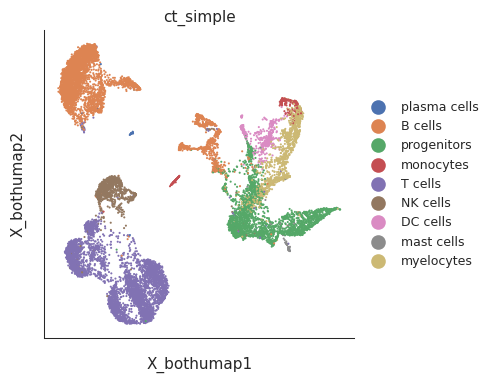

In [11]:
%%capture --no-display
sc.pl.embedding(adata,
           color="ct_simple", basis="X_bothumap", )

In [12]:
adata_myelo = adata[~(adata.obs.ct_simple.isin(["T cells", "B cells", "NK cells"]))]

/home/marii/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [13]:
adata_myelo

View of AnnData object with n_obs × n_vars = 4288 × 30539
    obs: 'Cluster_ID', 'donor_id', 'Cell_label', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'Genotype', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'ct_simple'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title', 'ct_simple_colors'
    obsm: 'X_bothtsne', 'X_bothumap', 'X_mofa', 'X_mofatsne', 'X_mofaumap', 'X_pca', 'X_projected', 'X_projectedmean'

### Visualise

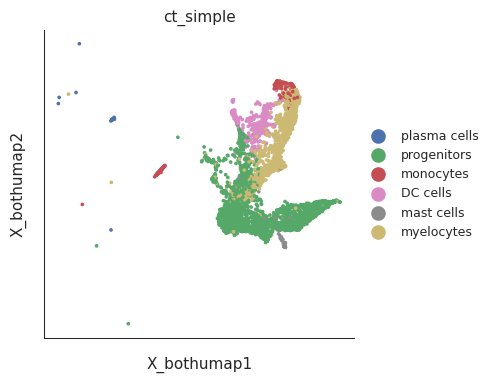

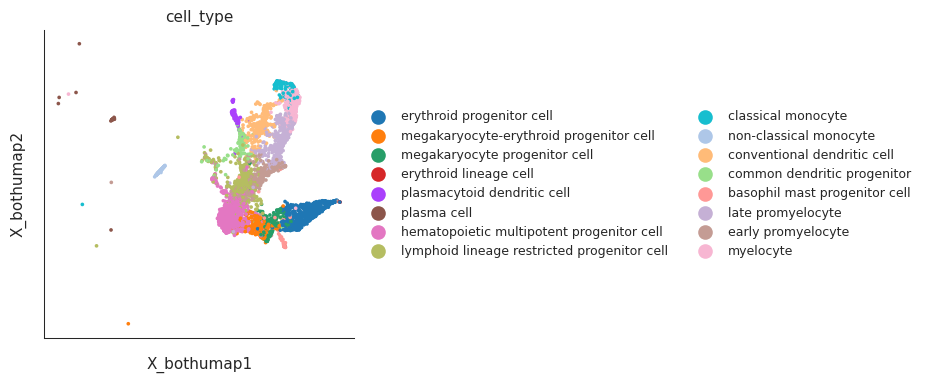

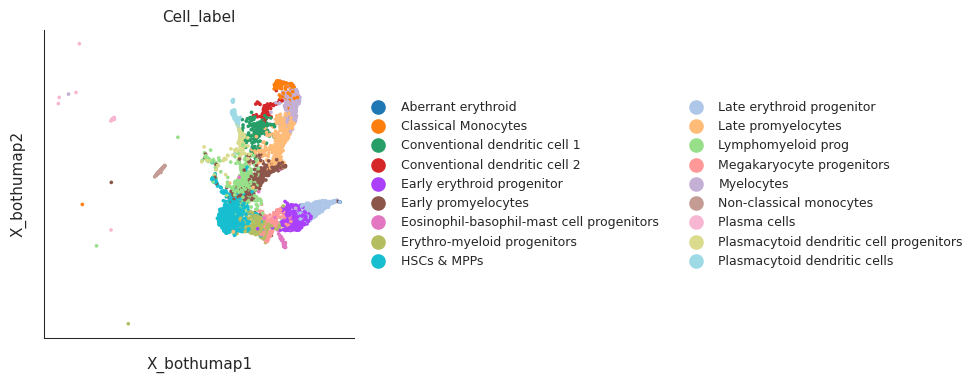

In [14]:
%%capture --no-display
sc.pl.embedding(adata_myelo,
           color="ct_simple", basis="X_bothumap", )
sc.pl.embedding(adata_myelo,
           color="cell_type", basis="X_bothumap", )
sc.pl.embedding(adata_myelo,
           color="Cell_label", basis="X_bothumap", )

In [15]:
adata_ref= adata_myelo[adata_myelo.obs.Cell_label != "Non-classical monocytes"]

adata_ref.obs["batch"] = "ref"
adata_ref.var.index = adata_ref.var.feature_name

/scratch/41867941/ipykernel_22303/3731777663.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [16]:
%%capture --no-display

adata_query = sc.read_h5ad("../../data/09-integration/d2n_SeuratObj_PostQC_dCas9_NewMD.h5ad")
adata_query.X = adata_query.X.toarray()
DE_data = pd.read_table("../../data/09-integration/d2n_DemuxHTOdCas9_Wilcoxon_AllGenesDE.tsv", sep="\t")
adata_query.obs["dosage_gene_log2FC"] = adata_query.obs.merge(DE_data[["guide_1", "dosage_gene_log2FC", "cell_line"]].drop_duplicates(), how="left", left_on=["short_ID", "cell_line"], right_on=["guide_1", "cell_line"])["dosage_gene_log2FC"].to_list()

In [17]:
adata_query.obs.head()

orig.ident  nCount_GDO  nFeature_GDO  num_features  \
L1_AAACCTGAGAAACCGC  SeuratProject        62.0             5           1.0   
L1_AAACCTGAGACTGGGT  SeuratProject       297.0             4           1.0   
L1_AAACCTGAGATATGGT  SeuratProject        84.0            13           1.0   
L1_AAACCTGAGGTTCCTA  SeuratProject        86.0            14           1.0   
L1_AAACCTGAGTAGCCGA  SeuratProject       262.0             7           1.0   

                                              guide_call num_umis num_guides  \
L1_AAACCTGAGAAACCGC  NFE2.chr12:54300900-54300919.+.A11G       58          1   
L1_AAACCTGAGACTGGGT    NFE2.chr12:54300595-54300614.+.WT      294          1   
L1_AAACCTGAGATATGGT   NFE2.chr12:54300900-54300919.+.C6A       69          1   
L1_AAACCTGAGGTTCCTA    NFE2.chr12:54300685-54300704.+.WT       69          1   
L1_AAACCTGAGTAGCCGA    MYB.chr6:135181906-135181887.-.WT      255          1   

                         cell_barcode  nCount_RNA  nFeature_RNA  nCount_HTO  \
L1_AAACCTGAGAAACCGC  AAACCTGAGAAACCGC      1172.0            78       533.0   
L1_AAACCTGAGACTGGGT  AAACCTGAGACTGGGT      1161.0            78       415.0   
L1_AAACCTGAGATATGGT  AAACCTGAGATATGGT      1956.0            74       669.0   
L1_AAACCTGAGGTTCCTA  AAACCTGAGGTTCCTA      1451.0            80       623.0   
L1_AAACCTGAGTAGCCGA  AAACCTGAGTAGCCGA      2166.0            77       355.0   

                     nFeature_HTO cell_line       L_cell_barcode  coord_start  \
L1_AAACCTGAGAAACCGC             8   CRISPRa  L1_AAACCTGAGAAACCGC     54300900   
L1_AAACCTGAGACTGGGT             8   CRISPRa  L1_AAACCTGAGACTGGGT     54300595   
L1_AAACCTGAGATATGGT             8   CRISPRi  L1_AAACCTGAGATATGGT     54300900   
L1_AAACCTGAGGTTCCTA             8   CRISPRa  L1_AAACCTGAGGTTCCTA     54300685   
L1_AAACCTGAGTAGCCGA             8   CRISPRi  L1_AAACCTGAGTAGCCGA    135181906   

                     coord_end                GUIDE_SEQ GUIDE_STRAND  \
L1_AAACCTGAGAAACCGC   54300919  GCTACCTTTGGGAATCTGCGAGG            +   
L1_AAACCTGAGACTGGGT   54300614  GAGCACCCAAGAAACCACTTAGG            +   
L1_AAACCTGAGATATGGT   54300919  GCTACATTTGAGAATCTGCGAGG            +   
L1_AAACCTGAGGTTCCTA   54300704  TCTCCTAGGATACCGAAAGTTGG            +   
L1_AAACCTGAGTAGCCGA  135181887  GGATCCCTCGCCGACACCCGCGG            -   

                         GUIDE_SEQ_NO_PAM  PAM  Doench2014OnTarget    Hsu2013  \
L1_AAACCTGAGAAACCGC  GCTACCTTTGGGAATCTGCG  AGG            0.850796  60.281609   
L1_AAACCTGAGACTGGGT  GAGCACCCAAGAAACCACTT  AGG            0.366384  78.467395   
L1_AAACCTGAGATATGGT  GCTACATTTGAGAATCTGCG  AGG            0.927845  56.477888   
L1_AAACCTGAGGTTCCTA  TCTCCTAGGATACCGAAAGT  TGG            0.115965  92.563933   
L1_AAACCTGAGTAGCCGA  GGATCCCTCGCCGACACCCG  CGG            0.697290  93.812766   

                     otCount guide_category  gene    chr  \
L1_AAACCTGAGAAACCGC       63     attenuated  NFE2  chr12   
L1_AAACCTGAGACTGGGT      130      titration  NFE2  chr12   
L1_AAACCTGAGATATGGT       81     attenuated  NFE2  chr12   
L1_AAACCTGAGGTTCCTA       65      titration  NFE2  chr12   
L1_AAACCTGAGTAGCCGA       48      titration   MYB   chr6   

                       genomic_GUIDE_PAM_SEQ  MM_NUM  MM_POS MM_WT_NT  \
L1_AAACCTGAGAAACCGC  GCTACCTTTGAGAATCTGCGAGG       1      11        A   
L1_AAACCTGAGACTGGGT  GAGCACCCAAGAAACCACTTAGG       0       0        -   
L1_AAACCTGAGATATGGT  GCTACCTTTGAGAATCTGCGAGG       1       6        C   
L1_AAACCTGAGGTTCCTA  TCTCCTAGGATACCGAAAGTTGG       0       0        -   
L1_AAACCTGAGTAGCCGA  GGATCCCTCGCCGACACCCGCGG       0       0        -   

                    MM_MUT_NT MM_ID                                   ID  \
L1_AAACCTGAGAAACCGC         G  A11G  NFE2_chr12:54300900-54300919_+_A11G   
L1_AAACCTGAGACTGGGT         -    WT    NFE2_chr12:54300595-54300614_+_WT   
L1_AAACCTGAGATATGGT         A   C6A   NFE2_chr12:54300900-54300919_+_C6A   
L1_AAACCTGAGGTTCCTA         -    WT    NFE2_chr12:54300685-54300704_+_WT   
L1_AAACCTGAG

In [18]:
adata_query = adata_query[:, ~adata_query.var_names.isin(["CRISPRi", "CRISPRa"])]
adata_query = adata_query[adata_query.obs.gene.isin(["MYB", "GFI1B", "NFE2"])]

/home/marii/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [19]:
%%capture --no-display

sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)

sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=2000,
)

adata_ref.var.loc[adata_ref.var.feature_name.isin(adata_query.var_names), "highly_variable"] = True
adata_ref.var.loc[adata_ref.var.feature_name.isin(["MYB", "GFI1B", "NFE2"]), "highly_variable"] = False
adata_ref = adata_ref[:, adata_ref.var.highly_variable]
adata_ref.raw = adata_ref
sc.pp.scale(adata_ref, max_value=10)
sc.pp.pca(adata_ref, n_comps=30, zero_center=False)#, use_highly_variable=False)
sc.pp.neighbors(adata_ref, use_rep="X_pca")
sc.tl.umap(adata_ref)

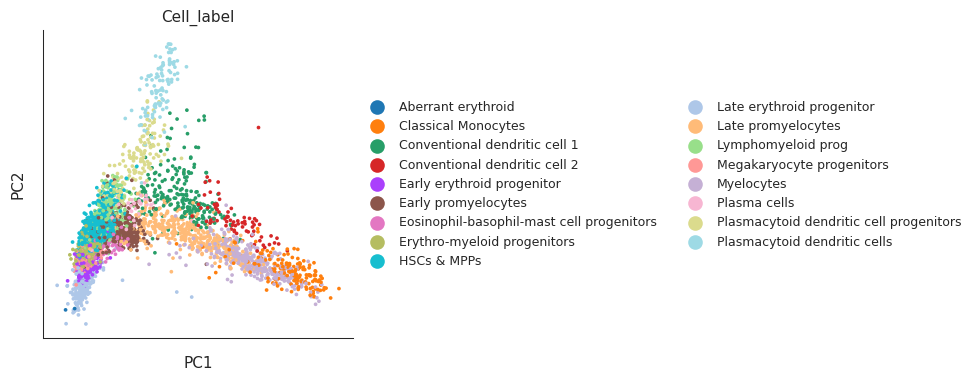

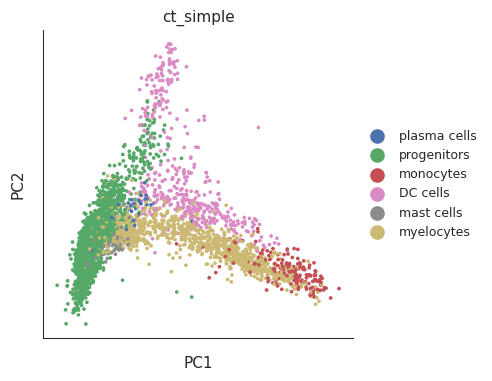

In [20]:
%%capture --no-display
sc.pl.pca(adata_ref,
           color="Cell_label")
sc.pl.pca(adata_ref, color="ct_simple")

In [21]:
sc.pp.normalize_total(adata_query, target_sum=1e4)
sc.pp.log1p(adata_query)
adata_query.obs[["MYB", "NFE2", "GFI1B"]] = adata_query[:, ["MYB", "NFE2", "GFI1B"]].X.tolist()

/home/marii/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
/home/marii/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [22]:
sc.pp.neighbors(adata_query)
sc.tl.umap(adata_query)

In [23]:
adata_query.obs.columns

Index(['orig.ident', 'nCount_GDO', 'nFeature_GDO', 'num_features',
       'guide_call', 'num_umis', 'num_guides', 'cell_barcode', 'nCount_RNA',
       'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'cell_line',
       'L_cell_barcode', 'coord_start', 'coord_end', 'GUIDE_SEQ',
       'GUIDE_STRAND', 'GUIDE_SEQ_NO_PAM', 'PAM', 'Doench2014OnTarget',
       'Hsu2013', 'otCount', 'guide_category', 'gene', 'chr',
       'genomic_GUIDE_PAM_SEQ', 'MM_NUM', 'MM_POS', 'MM_WT_NT', 'MM_MUT_NT',
       'MM_ID', 'ID', 'short_ID', 'guide_class', 'guide_crispr', 'ident',
       'dosage_gene_log2FC', 'MYB', 'NFE2', 'GFI1B'],
      dtype='object')

In [24]:
adata_query.obs.num_umis = adata_query.obs.num_umis.astype('int64')

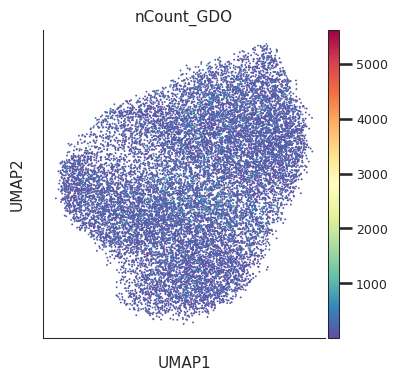

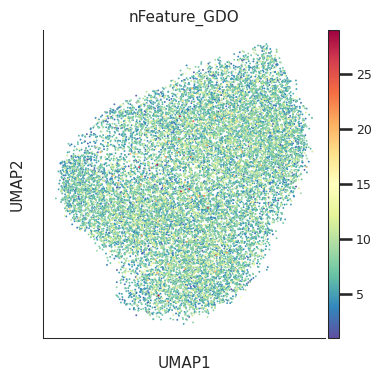

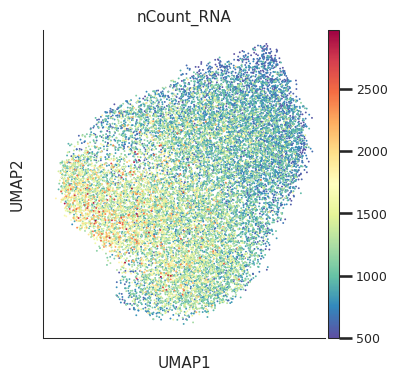

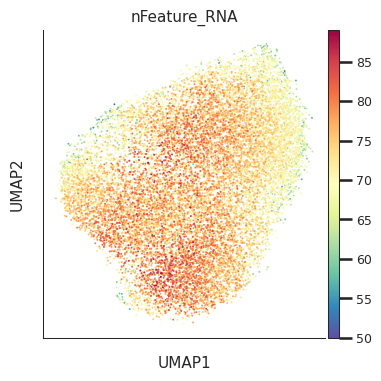

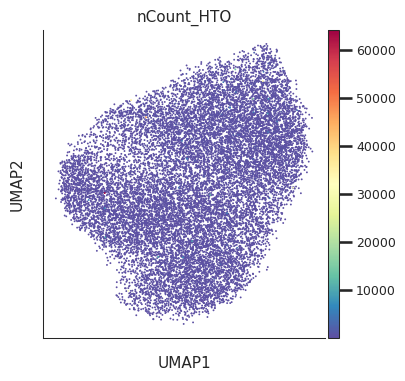

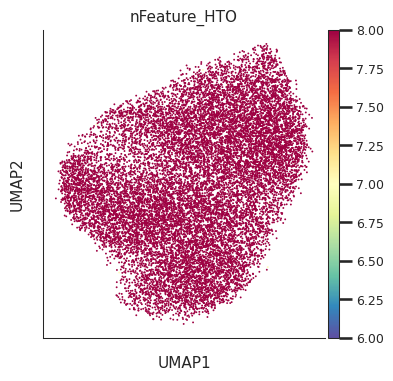

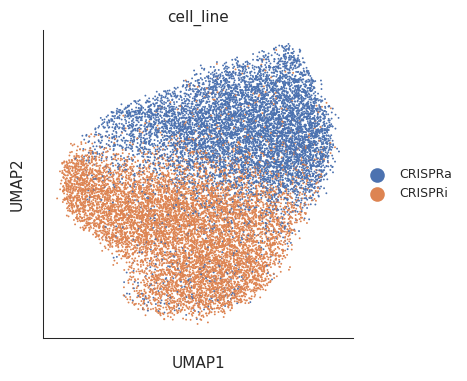

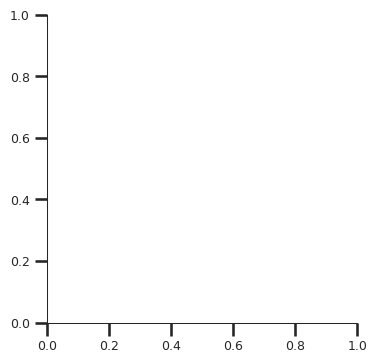

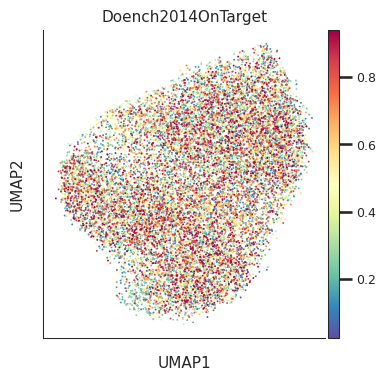

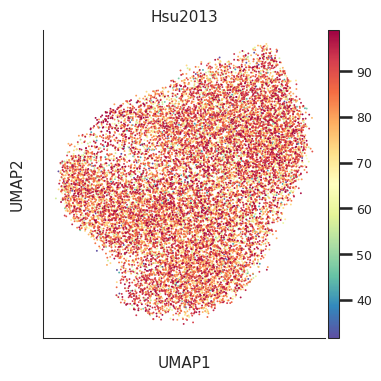

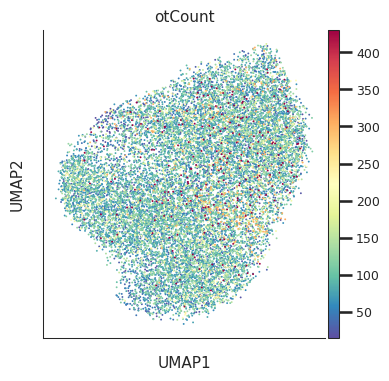

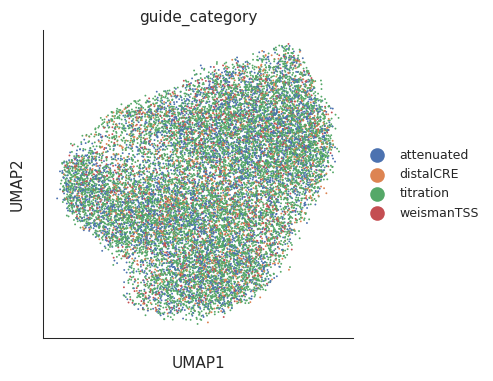

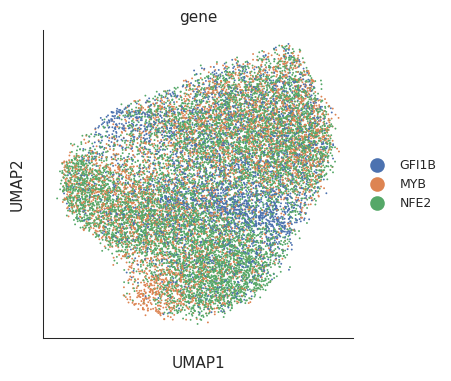

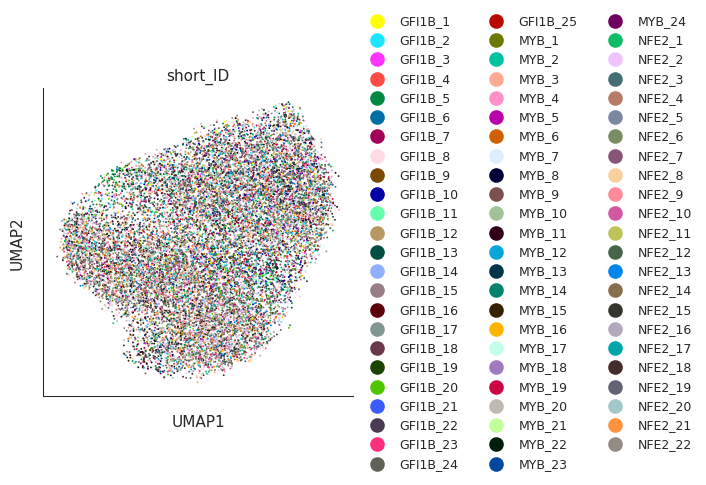

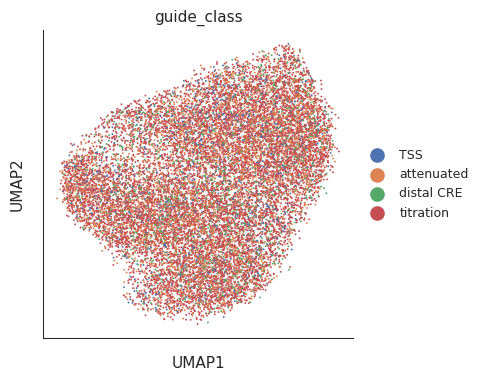

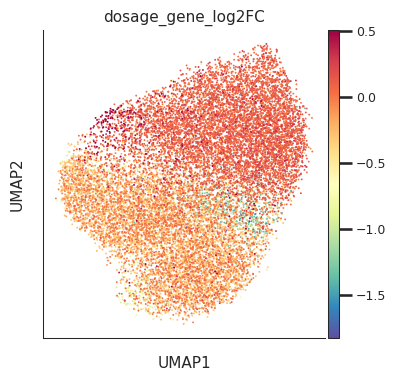

In [25]:
%%capture --no-display
for col in ['nCount_GDO', 'nFeature_GDO', 'nCount_RNA',
       'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'cell_line',
       'L_cell_barcode', 'Doench2014OnTarget',
       'Hsu2013', 'otCount', 'guide_category', 'gene', 'short_ID', 'guide_class',
       'dosage_gene_log2FC']:
    try:
        sc.pl.umap(adata_query, color=col)
    except:
        continue

### Pseudotemporal ordering

In [26]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata_ref, n_components=5,
                                           pca_key='X_pca')

Determing nearest neighbor graph...


In [27]:
ms_data = palantir.utils.determine_multiscale_space(adata_ref)

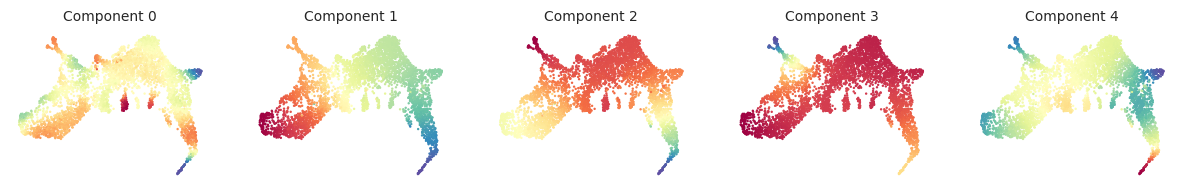

In [28]:
%%capture --no-display
palantir.plot.plot_diffusion_components(adata_ref, embedding_basis="X_umap")
plt.show()

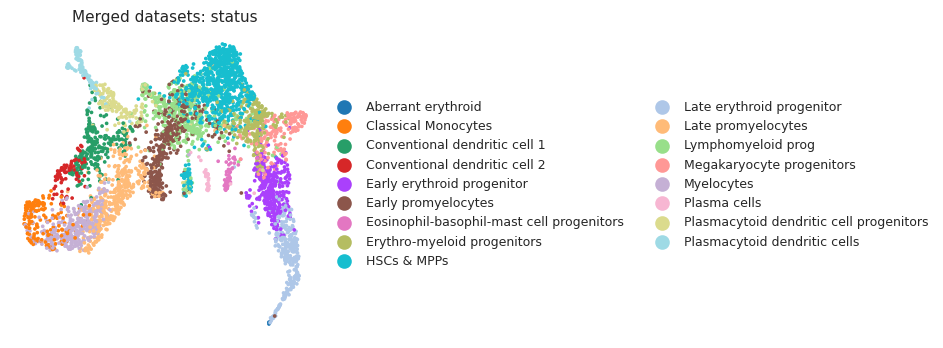

In [29]:
%%capture --no-display 
sc.pl.embedding(
    adata_ref,
    color="Cell_label",
    frameon=False,
    title="Merged datasets: status",basis="X_umap"
    #legend_loc=None,
)

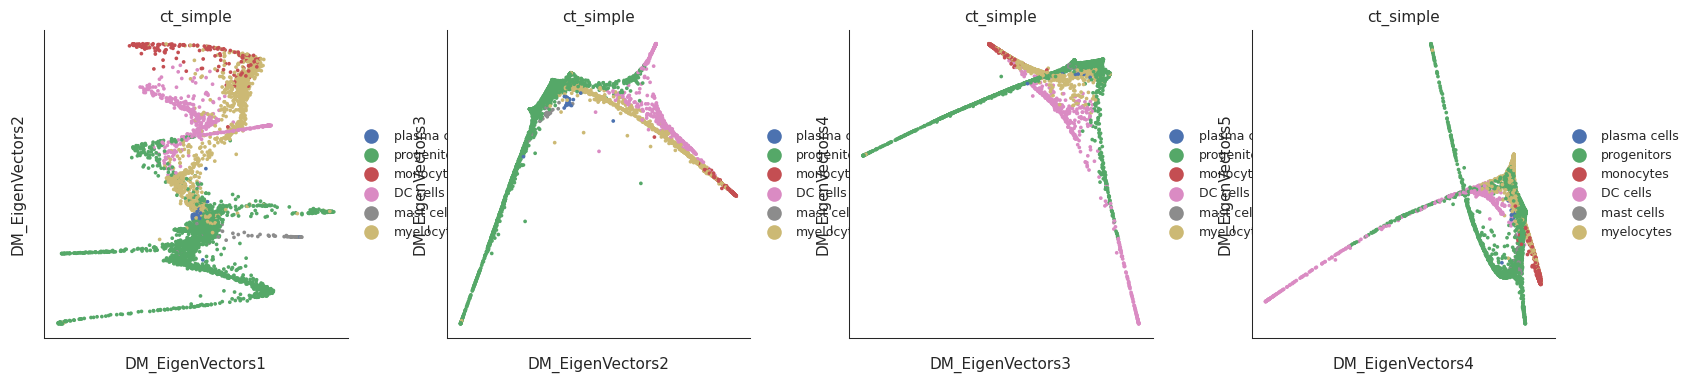

In [30]:
%%capture --no-display
sc.pl.embedding(adata_ref, color="ct_simple", basis="DM_EigenVectors", dimensions=[(0, 1), (1, 2), (2, 3), (3, 4)])

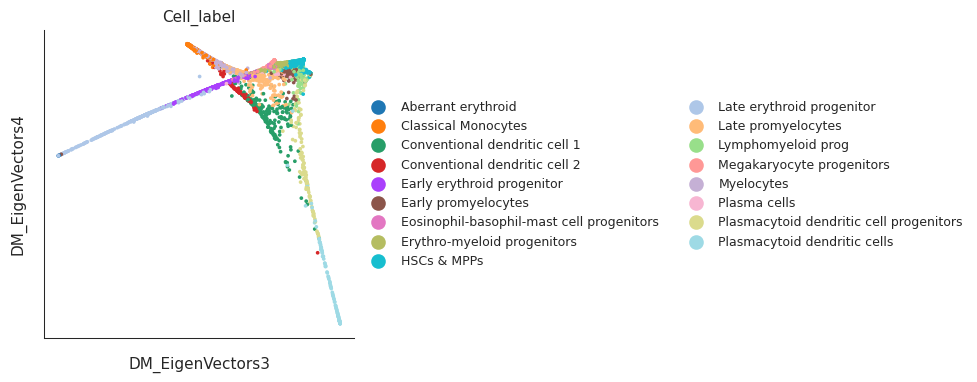

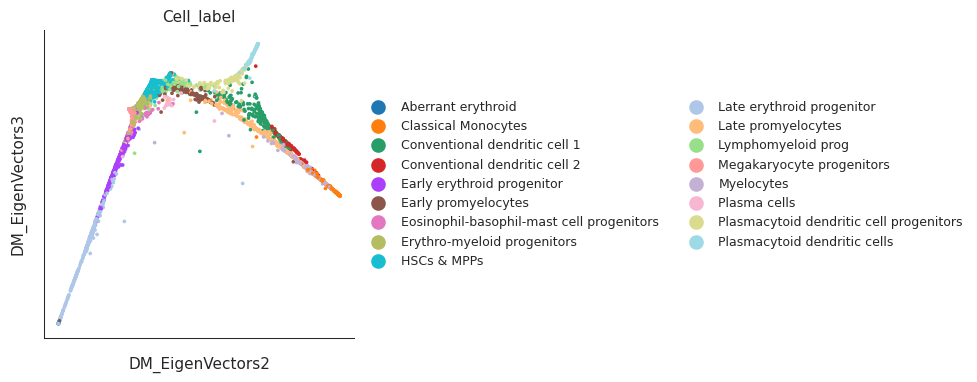

In [31]:
%%capture --no-display
sc.pl.embedding(adata_ref, color="Cell_label", basis="DM_EigenVectors", dimensions=[(2, 3)])
sc.pl.embedding(adata_ref, color="Cell_label", basis="DM_EigenVectors", dimensions=[(1, 2)])

In [32]:
for ct in adata.obs.Cell_label.drop_duplicates():
    temp = pd.DataFrame(adata_ref[adata_ref.obs.Cell_label == ct].obsm["DM_EigenVectors"][:, 2:])
    temp.index = adata_ref[adata_ref.obs.Cell_label == ct].obs.index
    try:
        print(f'{ct}\t max: {temp[0].idxmax()} min: {temp[0].idxmin()}\t min_3: {temp[1].idxmin()} max_3: {temp[1].idxmax()}')
    except:
        pass

Late erythroid progenitor	 max: 97453 min: 489540	 min_3: 489540 max_3: 97453
Conventional dendritic cell 1	 max: 724166 min: 459394	 min_3: 724166 max_3: 459394
Late promyelocytes	 max: 804472 min: 652462	 min_3: 379566 max_3: 652462
Megakaryocyte progenitors	 max: 385537 min: 738705	 min_3: 738705 max_3: 632304
Early promyelocytes	 max: 230815 min: 722656	 min_3: 722656 max_3: 558518
Lymphomyeloid prog	 max: 128380 min: 423706	 min_3: 216858 max_3: 419418
Early erythroid progenitor	 max: 136572 min: 466410	 min_3: 466410 max_3: 482028
Myelocytes	 max: 802417 min: 173839	 min_3: 444086 max_3: 173839
Conventional dendritic cell 2	 max: 596357 min: 779057	 min_3: 596357 max_3: 779057
Eosinophil-basophil-mast cell progenitors	 max: 104788 min: 367057	 min_3: 367057 max_3: 489464
Plasmacytoid dendritic cell progenitors	 max: 874145 min: 783624	 min_3: 874145 max_3: 691966
HSCs & MPPs	 max: 196874 min: 149280	 min_3: 402987 max_3: 215263
Plasma cells	 max: 195527 min: 141465	 min_3: 141465

In [33]:
terminal_states = pd.Series(
    ["Conventional dendritic cell 2", 
     "Megakaryocyte progenitors", 
     "Myelocytes", 
     "Eosinophil-basophil-mast cell progenitors", 
     "Plasmacytoid dendritic cells", 
     "Classical Monocytes", 
     "Aberrant erythroid"],
    index=["779057", 
           "254130", 
           "173839", 
           "489464", 
           "874145", 
           "150939", 
           "783947"]
)

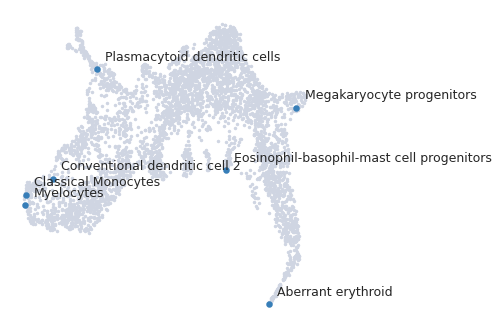

In [34]:
%%capture --no-display
palantir.plot.highlight_cells_on_umap(adata_ref, terminal_states, embedding_basis="X_umap")
plt.show()

In [35]:
ct = "HSCs & MPPs"
temp = pd.DataFrame(adata_ref[adata_ref.obs.Cell_label == ct].obsm["DM_EigenVectors"][:, 1:])
temp.index = adata_ref[adata_ref.obs.Cell_label == ct].obs.index
temp[temp[0]==temp[0].quantile(interpolation='nearest', 
                               q=0.752)]

0         1         2         3
517415 -0.007193  0.012155  0.007021  0.004303

In [36]:
temp.index

Index(['642391', '118872', '275602', '52656', '647916', '1319', '343566',
       '842712', '227063', '801985',
       ...
       '676225', '691210', '850979', '138810', '855034', '212406', '855119',
       '856037', '850357', '555503'],
      dtype='object', length=805)

In [37]:
dist = ((temp - temp.mean(axis=0))**2).sum(axis=1).sort_values()
#dist["idx"] = dist.index.to_list()
dist = dist.reset_index()
dist[dist["index"] == "681414"]

/home/marii/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


index             0
0  681414  2.232074e-08

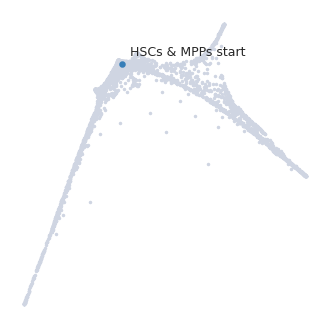

In [38]:
%%capture --no-display
adata_ref.obsm["DM"] = adata_ref.obsm["DM_EigenVectors"][:, 1:3]
palantir.plot.highlight_cells_on_umap(adata_ref, pd.Series(
    ["HSCs & MPPs start"], index=["681414"]), embedding_basis="DM")
plt.show()

In [39]:
%%capture --no-display
start_cell = "681414"
pr_res = palantir.core.run_palantir(
    adata_ref, start_cell, num_waypoints=500, terminal_states=terminal_states, use_early_cell_as_start=True
)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Fa

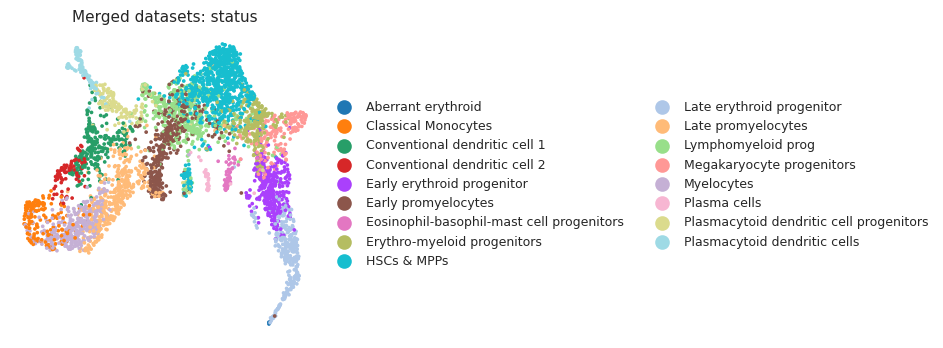

In [40]:
%%capture --no-display 
sc.pl.embedding(
    adata_ref,
    color="Cell_label",
    frameon=False,
    title="Merged datasets: status", basis="X_umap"
    #legend_loc=None,
)

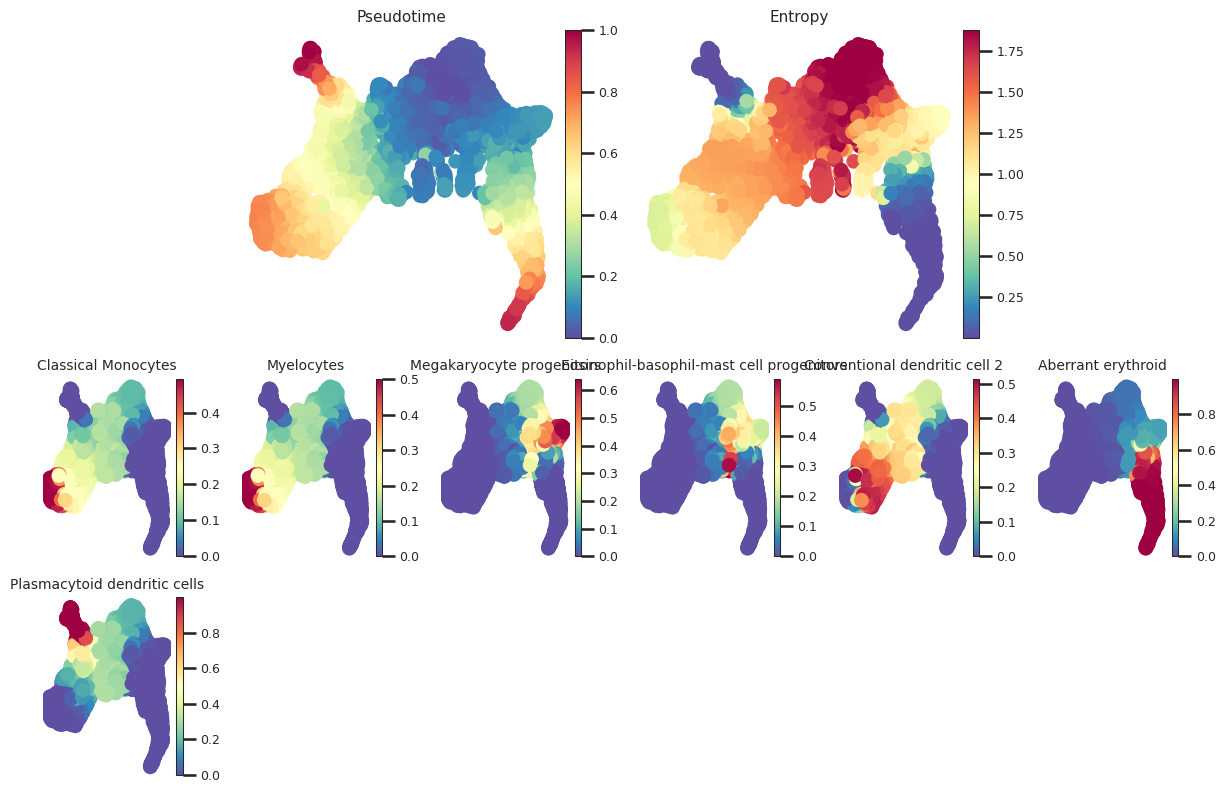

In [41]:
%%capture --no-display
palantir.plot.plot_palantir_results(adata_ref, embedding_basis="X_umap")
plt.show()

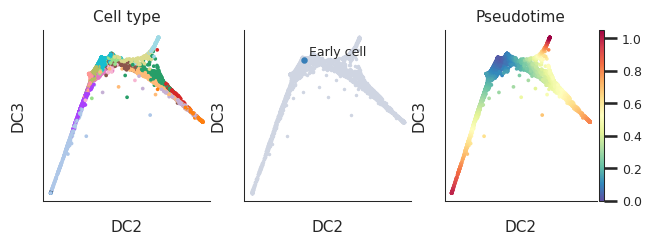

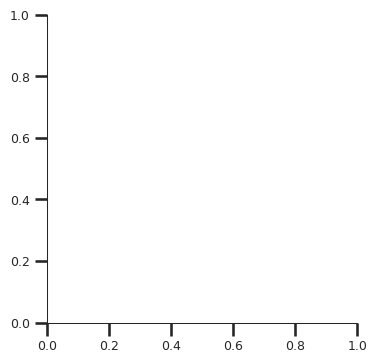

In [42]:
%%capture --no-display
fig, axes = plt.subplots(ncols=3, figsize=(7.3425, 2.225))#, layout="tight")
adata_ref.obsm["DM"] = adata_ref.obsm["DM_EigenVectors"][:, 1:3]
sc.pl.embedding(adata_ref, color="Cell_label", basis="DM_EigenVectors", legend_loc=None, 
                dimensions=[(1, 2)], ax=axes[0], show=False, title="Cell type")
palantir.plot.highlight_cells_on_umap(adata_ref, pd.Series(
    ["Early cell"], index=["681414"]), embedding_basis="DM", ax=axes[1])
sc.pl.embedding(adata_ref, color="palantir_pseudotime", basis="DM_EigenVectors", 
                dimensions=[(1, 2)], ax=axes[2], show=False, title="Pseudotime")
axes[1].set_axis_on()
axes[1].set_xticks([])
axes[1].set_yticks([])
for ax in axes:
    ax.set_xlabel("DC2")
    ax.set_ylabel("DC3")
fig.savefig("../../plots/09-integration/Panel_B_triana.svg", pad_inches=0.0, dpi=720)

In [44]:
masks = palantir.presults.select_branch_cells(adata_ref, eps=0)

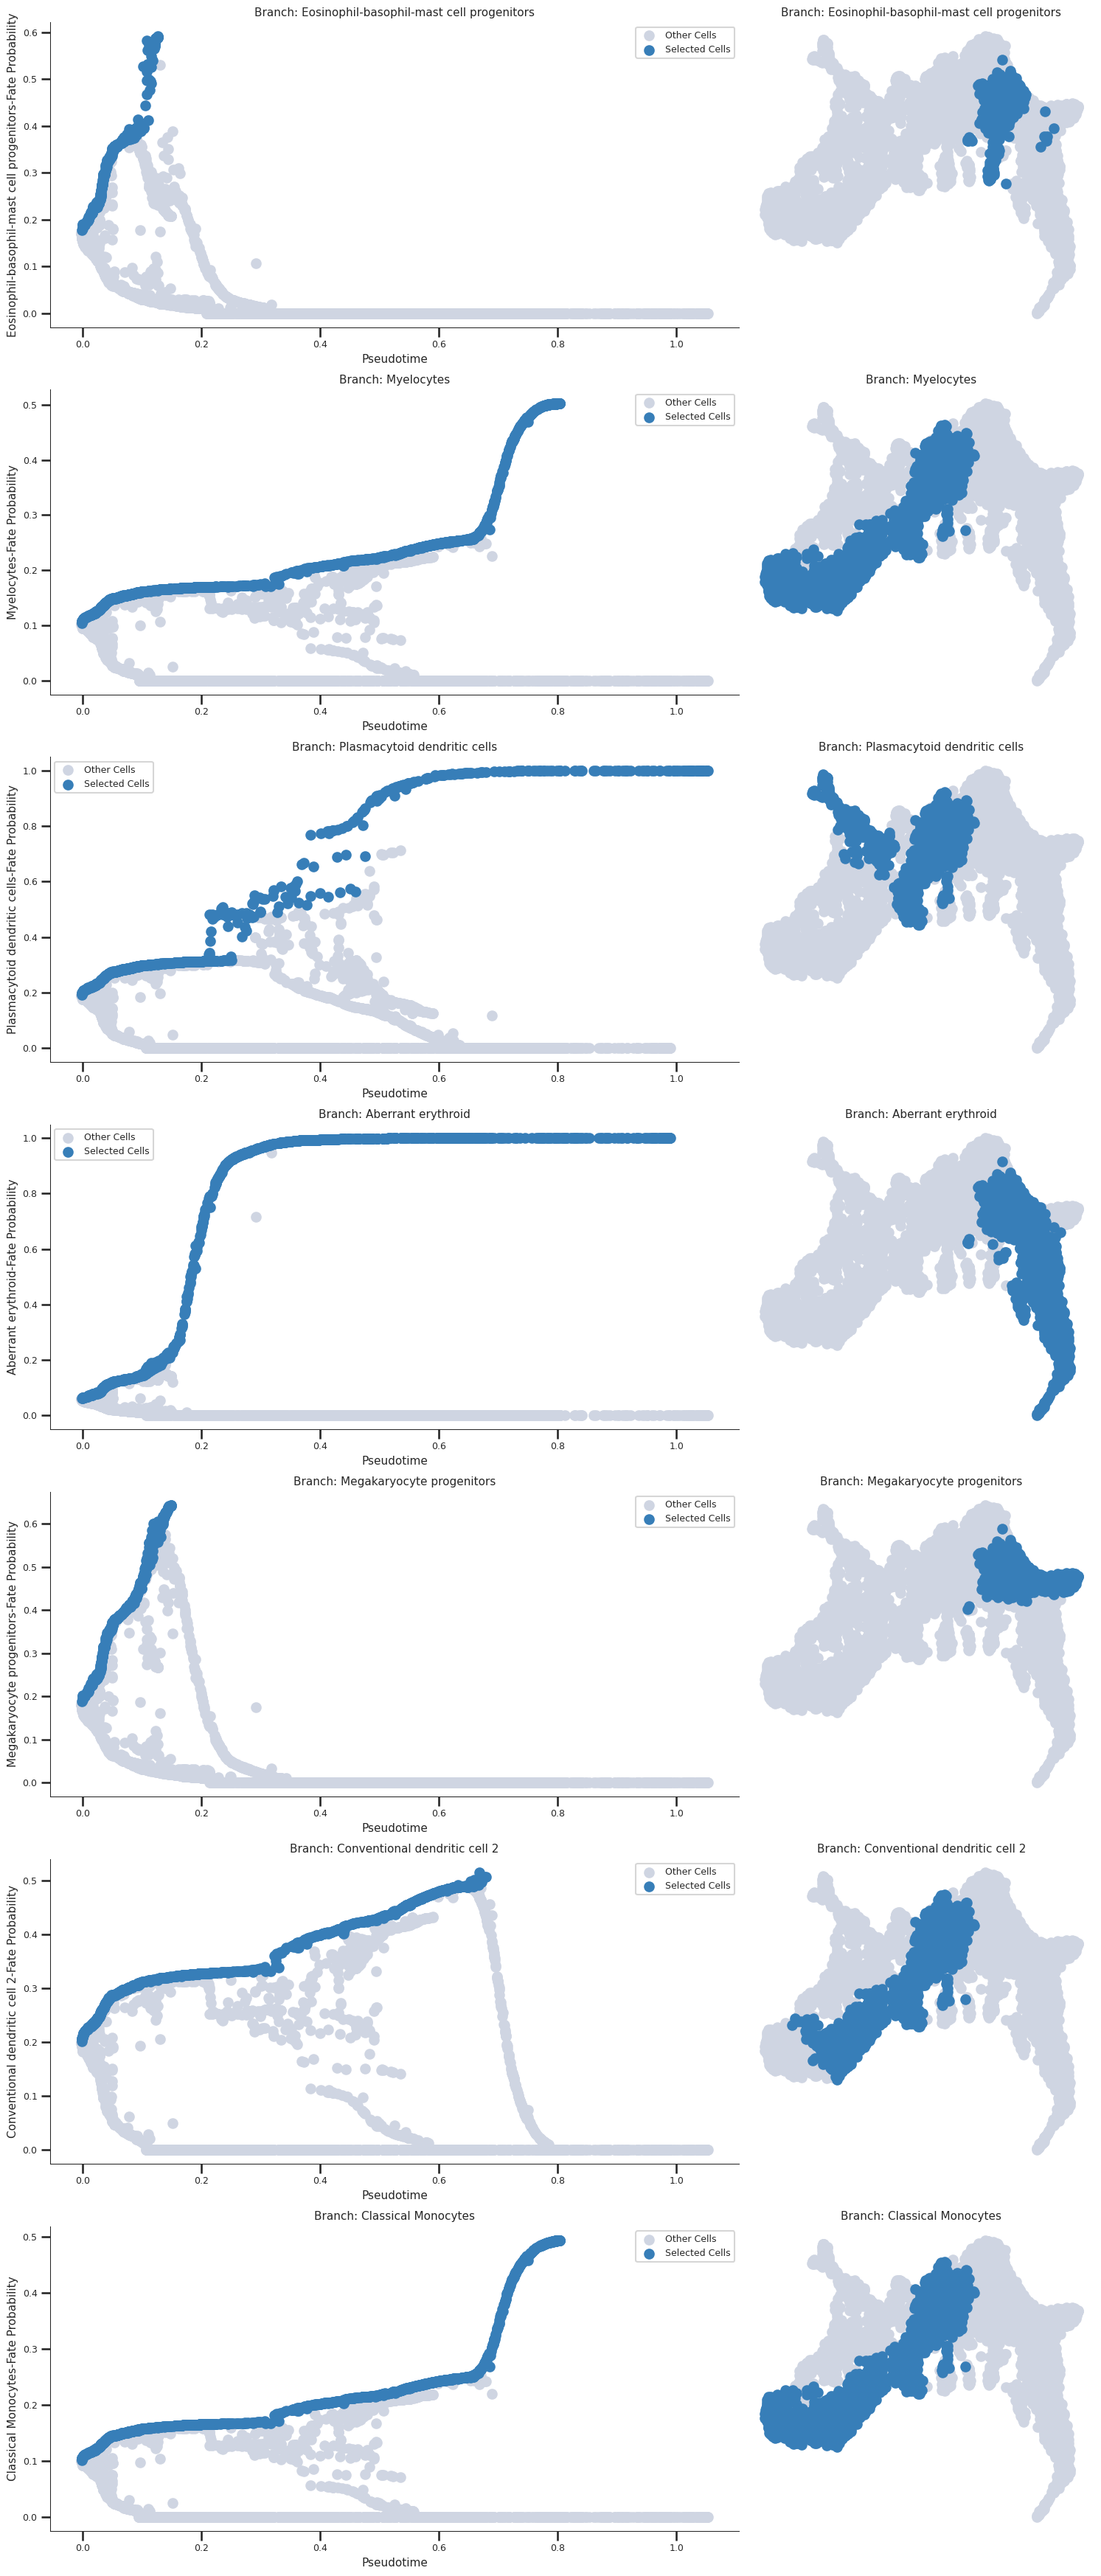

In [45]:
%%capture --no-display
palantir.plot.plot_branch_selection(adata_ref, embedding_basis="X_umap")
plt.show()

In [46]:
gene_trends = palantir.presults.compute_gene_trends(
    adata_ref, 
)

Classical Monocytes
[2023-10-17 16:33:54,545] [INFO    ] Using covariance function Matern52(ls=10.0).
Myelocytes
[2023-10-17 16:33:56,528] [INFO    ] Using covariance function Matern52(ls=10.0).
Megakaryocyte progenitors
[2023-10-17 16:33:56,866] [INFO    ] Using covariance function Matern52(ls=10.0).
Eosinophil-basophil-mast cell progenitors
[2023-10-17 16:33:58,197] [INFO    ] Using covariance function Matern52(ls=10.0).
Conventional dendritic cell 2
[2023-10-17 16:33:59,496] [INFO    ] Using covariance function Matern52(ls=10.0).
Aberrant erythroid
[2023-10-17 16:34:01,239] [INFO    ] Using covariance function Matern52(ls=10.0).
Plasmacytoid dendritic cells
[2023-10-17 16:34:03,058] [INFO    ] Using covariance function Matern52(ls=10.0).


### Reference mapping with Symphony

In [47]:
from sklearn.neighbors import KNeighborsRegressor

def transfer_continous_kNN(adata_ref, adata_query, ref_keys, ref_basis, 
                           query_basis,  query_keys=None, *kNN_args, **kNN_kwargs) -> None:
    if query_keys is None:
        query_keys = ref_keys
    knn_reg = KNeighborsRegressor(*kNN_args, **kNN_kwargs)
    knn_reg.fit(adata_ref.obsm[ref_basis], adata_ref.obs[ref_keys])
    feature_pred = knn_reg.predict(adata_query.obsm[query_basis])
    if isinstance(ref_keys, list) and len(ref_keys) == 1:
        feature_pred = feature_pred.reshape(feature_pred.shape[0], 1)
    adata_query.obs[ref_keys] = feature_pred
    

In [48]:
# Running Symphony
sp.tl.map_embedding(
    adata_query=adata_query,
    adata_ref=adata_ref,
    use_genes_column=None, 
    
)

/home/marii/.local/lib/python3.10/site-packages/symphonypy/tools.py:307: UserWarning: Not found `harmony` object in adata_ref.uns.
Assuming that adata_ref doesn't have any batches, and using 'X_pca' representation of adata_ref for clustering.
Otherwise, firstly run symphonypy.pp.harmony_integrate on adata_ref to account for them.
/home/marii/.local/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
1985 out of 2072 genes from the reference are missing in the query dataset or have zero std in the reference, their expressions in the query will be set to zero


In [49]:
# Labels prediction

sp.tl.transfer_labels_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_labels=["cell_type", "ct_simple", "Cell_label"],
    ref_basis="X_pca",
    query_basis="X_pca_harmony",
)

In [50]:
adata_ref

AnnData object with n_obs × n_vars = 4191 × 2072
    obs: 'Cluster_ID', 'donor_id', 'Cell_label', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'Genotype', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'ct_simple', 'batch', 'palantir_pseudotime', 'palantir_entropy'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title', 'ct_simple_colors', 'cell_type_colors', 'Cell_label_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'DM_EigenValues', 'palantir_waypoints', 'harmony'
    obsm: 'X_botht

In [51]:
transfer_continous_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_keys=["palantir_pseudotime", "palantir_entropy"],
    ref_basis="X_pca",
    query_basis="X_pca_harmony",
)

In [52]:
merged = adata_ref.concatenate(adata_query)

/home/marii/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/marii/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [53]:
merged.obsm["X_pca"] = np.concatenate([adata_ref.obsm["X_pca"], 
                                             adata_query.obsm["X_pca_harmony"]])

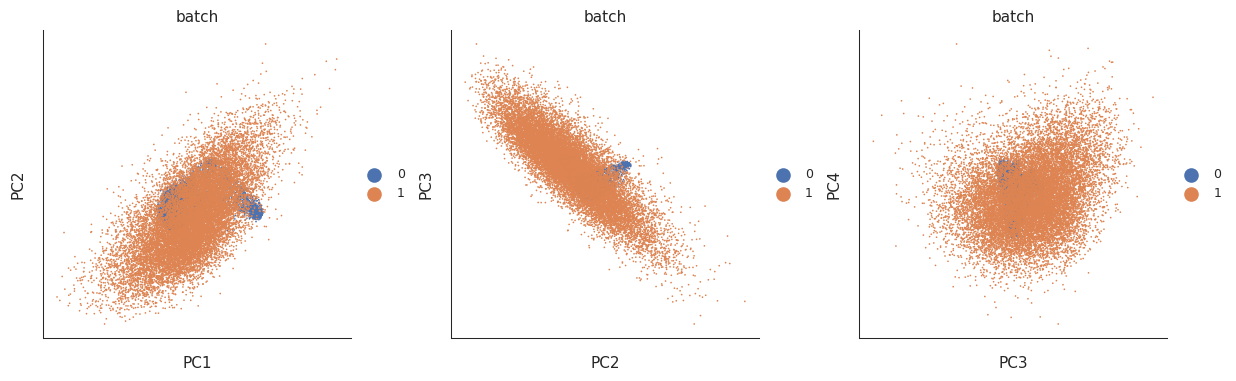

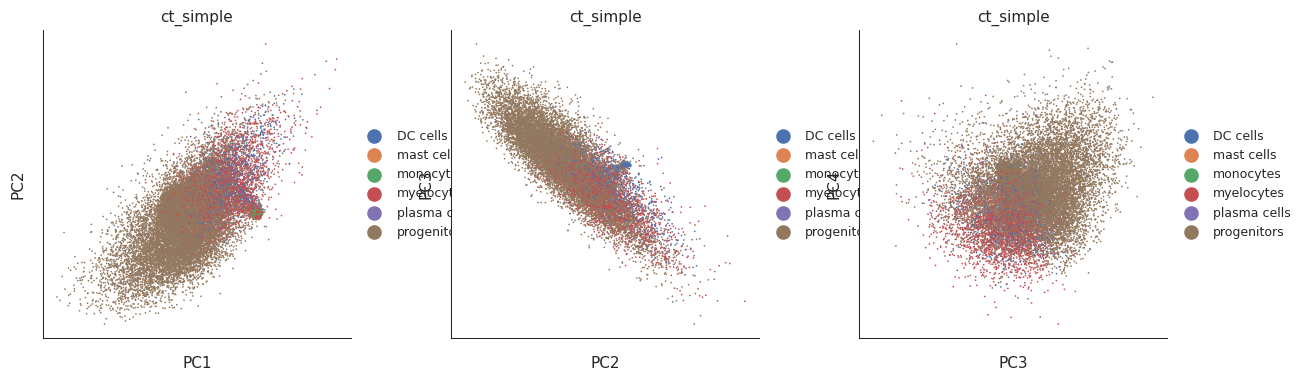

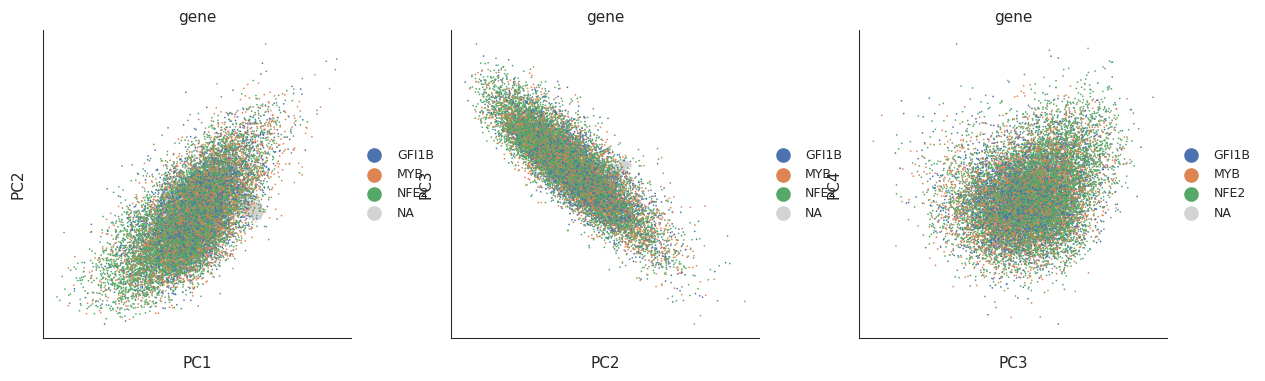

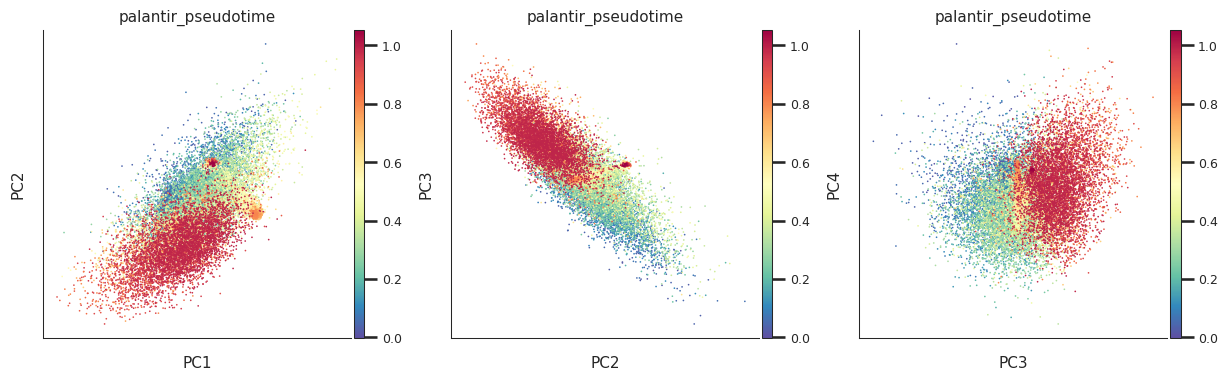

In [54]:
%%capture --no-display 
sc.pl.pca(merged, color="batch", dimensions=[(0, 1), (1, 2), (2, 3)])
sc.pl.pca(merged, color="ct_simple", dimensions=[(0, 1), (1, 2), (2, 3)])
sc.pl.pca(merged, color="gene", dimensions=[(0, 1), (1, 2), (2, 3)])
sc.pl.pca(merged, color="palantir_pseudotime", dimensions=[(0, 1), (1, 2), (2, 3)])

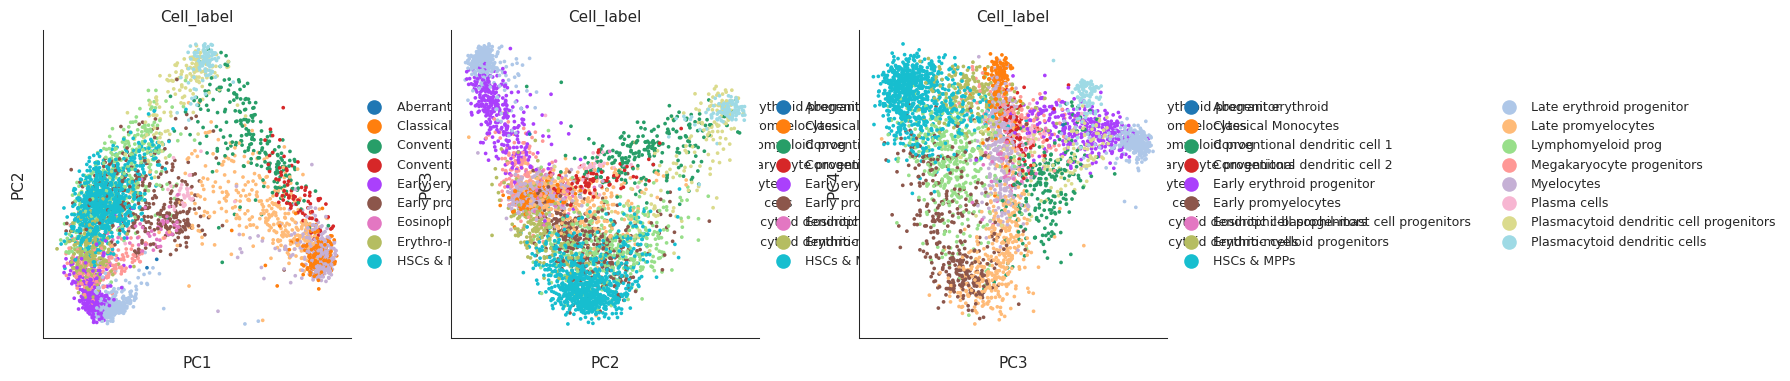

In [55]:
%%capture --no-display 
sc.pl.pca(adata_ref, color="Cell_label", dimensions=[(0, 1), (1, 2), (2, 3)])

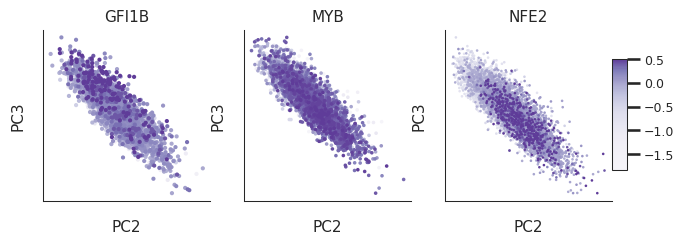

In [57]:
%%capture --no-display 
import matplotlib.cm as cm
from matplotlib.colors import Normalize, ListedColormap

fig, axes = plt.subplots(ncols=3, figsize=(7.3425, 2.225))
lvTmp = np.logspace(-4, -0.3, 100, base=2)
cmTmp = cm.Purples(lvTmp)
cmap = ListedColormap(cmTmp)
sc.pl.embedding(
    adata_query[adata_query.obs.gene == "GFI1B"],
    color="dosage_gene_log2FC",
    #frameon=False,
    color_map=cmap,
    colorbar_loc=None, 
    use_raw=False,
    title="GFI1B",basis='X_pca_harmony', dimensions=(1,2), ax=axes[0], show=False
)

sc.pl.embedding(
    adata_query[adata_query.obs.gene == "MYB"],
    color="dosage_gene_log2FC",
    color_map=cmap,
    colorbar_loc=None, 
    use_raw=False,
    title="MYB",basis='X_pca_harmony', dimensions=(1,2), ax=axes[1], show=False, 
)
sc.pl.embedding(
    adata_query[adata_query.obs.gene == "NFE2"],
    color="dosage_gene_log2FC",
    color_map=cmap,
    colorbar_loc=None, 
    use_raw=False,
    title="NFE2",basis='X_pca_harmony', dimensions=(1,2), ax=axes[2], show=False
)
for ax in axes:
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC3")
fig.subplots_adjust(right=0.9)
normalizer=Normalize(vmin=adata_query.obs["dosage_gene_log2FC"].min(), 
                     vmax=adata_query.obs["dosage_gene_log2FC"].max())
im=cm.ScalarMappable(norm=normalizer, cmap=cmap)
cbar_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, ticks=[-1.5, -1, -0.5, 0.0, 0.5], )
fig.savefig("../../plots/09-integration/Panel_C_triana.svg", pad_inches=0.0, dpi=720)

In [58]:
sc.pp.neighbors(merged)
sc.tl.umap(merged)

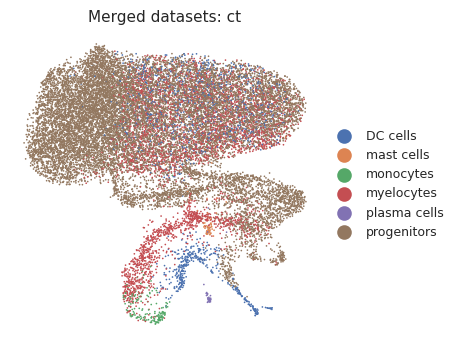

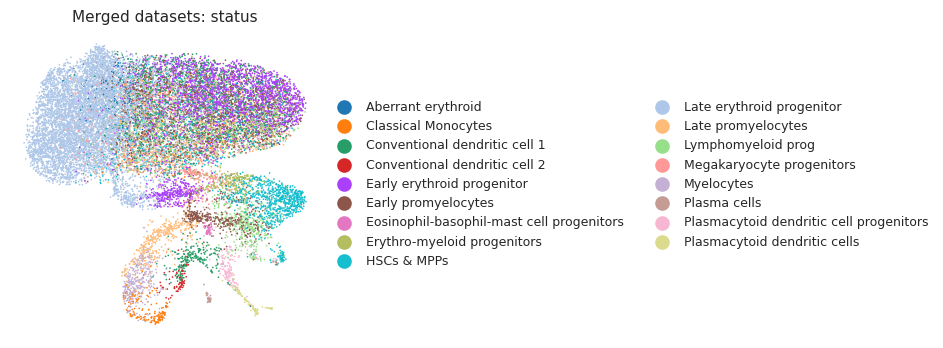

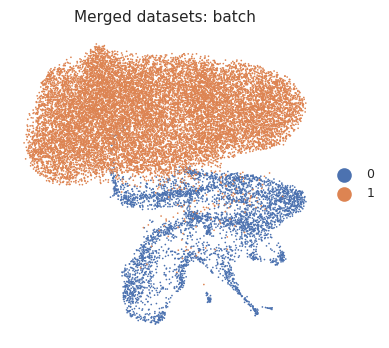

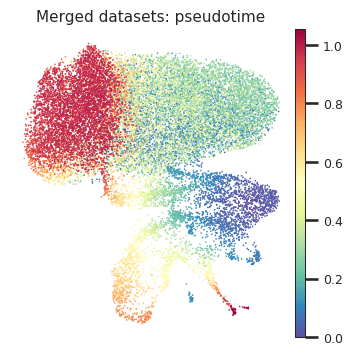

In [59]:
%%capture --no-display 

sc.pl.umap(
    merged,
    color="ct_simple",
    frameon=False,
    title="Merged datasets: ct"
    #legend_loc=None,
)

sc.pl.umap(
    merged,
    color="Cell_label",
    frameon=False,
    title="Merged datasets: status",
    #legend_loc=None,
)

sc.pl.umap(
    merged,
    color="batch",
    frameon=False,
    title="Merged datasets: batch",
)

sc.pl.umap(
    merged,
    color="palantir_pseudotime",
    frameon=False,
    title="Merged datasets: pseudotime",
)

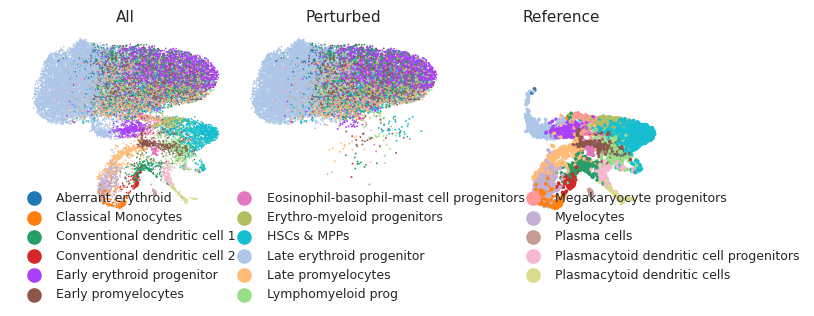

In [60]:
%%capture --no-display 
fig, axes = plt.subplots(ncols=3, figsize=(6.675, 2.34), sharex=True, sharey=True, 
                         layout="tight")
sc.pl.umap(
    merged,
    color="Cell_label",
    frameon=False,
    title="All",
    ax=axes[0],
    legend_loc=None,
    show=False
)

sc.pl.umap(
    merged[merged.obs.batch == "1"],
    color="Cell_label",
    frameon=False,
    title="Perturbed",
    ax=axes[1],
    legend_loc=None,
    show=False
)


sc.pl.umap(
    merged[merged.obs.batch == "0"],
    color="Cell_label",
    frameon=False,
    title="Reference",
    ax=axes[2],
    show=False
    #legend_loc=None,
)

h, l = axes[2].get_legend_handles_labels()
axes[2].legend().set_visible(False)
fig.subplots_adjust(bottom=0.2)
leg_ax = fig.add_axes([0.0, 0.0, 1.0, 0.1], frame_on=False)
leg_ax.set_axis_off()
leg_ax.legend(h, l, loc="lower center",  mode = "expand", ncol = 3, 
              bbox_to_anchor=(0.0, -3.5, 1.2, 1.0), frameon=False)
fig.savefig("../../plots/09-integration/Panel_A_triana.svg", )

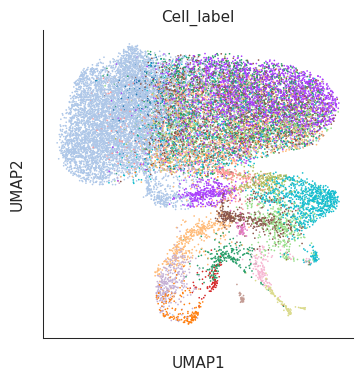

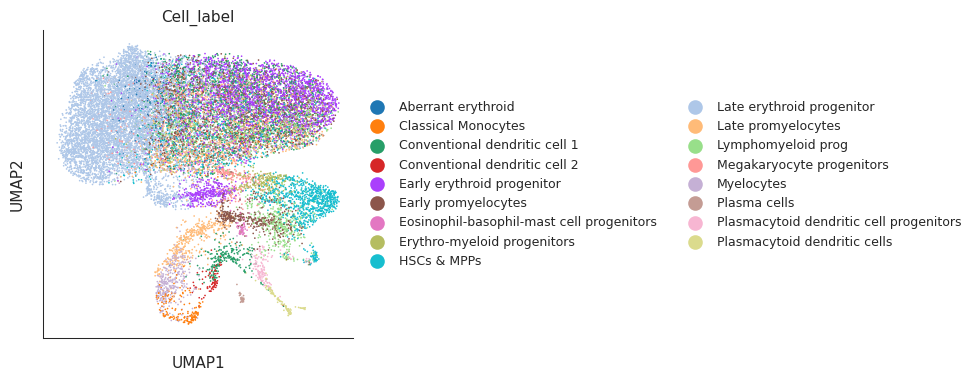

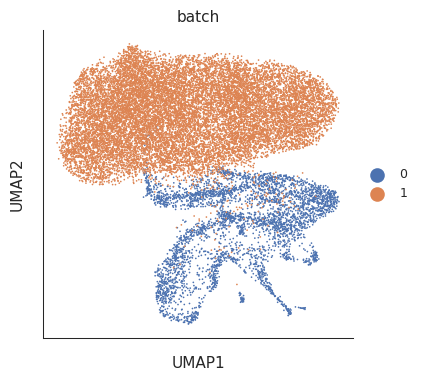

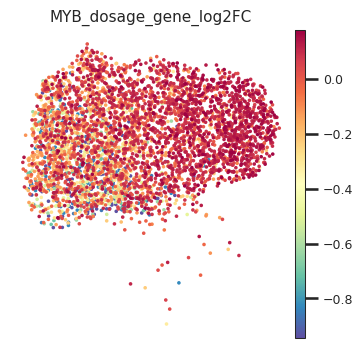

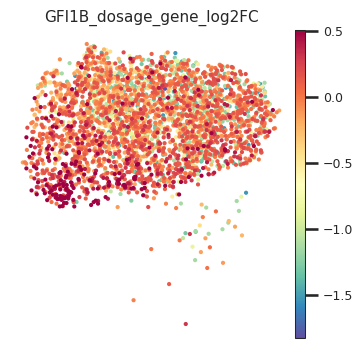

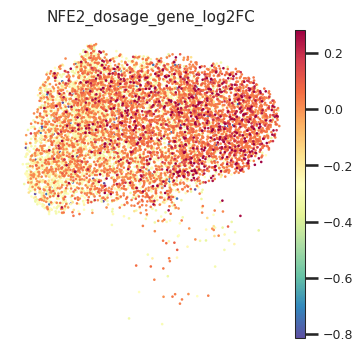

In [61]:
%%capture --no-display 
sc.pl.umap(merged, color="Cell_label", use_raw=False, legend_loc=None)
sc.pl.umap(merged, color="Cell_label", use_raw=False)
sc.pl.umap(merged, color="batch",    use_raw=False)
#sc.pl.umap(merged, color=["MYB", "NFE2", "GFI1B"],     use_raw=False)
"""sc.pl.umap(
    merged[merged.obs.batch == "0"],
    color=["MYB", "NFE2", "GFI1B"],
    frameon=False,
    use_raw=False
)"""
sc.pl.umap(
    merged[merged.obs.gene == "MYB"],
    color="dosage_gene_log2FC",
    frameon=False,
    use_raw=False,
    title="MYB_dosage_gene_log2FC"
)

sc.pl.umap(
    merged[merged.obs.gene == "GFI1B"],
    color="dosage_gene_log2FC",
    frameon=False,
    use_raw=False,
    title="GFI1B_dosage_gene_log2FC"
)
sc.pl.umap(
    merged[merged.obs.gene == "NFE2"],
    color="dosage_gene_log2FC",
    frameon=False,
    use_raw=False,
    title="NFE2_dosage_gene_log2FC"
)

In [62]:
adata_query.obs.Cell_label.value_counts()

Late erythroid progenitor                    6864
Early erythroid progenitor                   2536
Early promyelocytes                          1614
Conventional dendritic cell 1                1275
Late promyelocytes                            905
Lymphomyeloid prog                            867
HSCs & MPPs                                   728
Megakaryocyte progenitors                     585
Erythro-myeloid progenitors                   426
Aberrant erythroid                            247
Myelocytes                                    137
Eosinophil-basophil-mast cell progenitors      41
Classical Monocytes                            38
Plasmacytoid dendritic cell progenitors        23
Plasma cells                                   21
Conventional dendritic cell 2                  10
Plasmacytoid dendritic cells                    1
Name: Cell_label, dtype: int64

In [63]:
%%capture --no-display
unintegr = adata_ref.concatenate(adata_query)
sc.pp.pca(unintegr)
sc.pp.neighbors(unintegr)
unintegr.obs.batch = unintegr.obs.batch.astype("category")
unintegr.obs.Cell_label = unintegr.obs.Cell_label.astype("category")
merged.obs.batch = merged.obs.batch.astype("category")
merged.obs.Cell_label = merged.obs.Cell_label.astype("category")
'''sc.pp.neighbors(merged)'''
metrics_symphony = scib.metrics.metrics_fast(
    merged, unintegr, batch_key='batch', label_key='Cell_label', embed="X_umap"
)
metrics_symphony

0
NMI_cluster/label               NaN
ARI_cluster/label               NaN
ASW_label                  0.423687
ASW_label/batch            0.347309
PCR_batch                  0.765392
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.549653
graph_conn                 0.646352
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                1.000000
trajectory                      NaN

In [64]:
to_plot = adata_query.obs[["gene", "palantir_pseudotime", "MYB", "NFE2", "GFI1B"]]
to_plot = pd.melt(to_plot, id_vars=["gene", "palantir_pseudotime"], value_vars=["MYB", "NFE2", "GFI1B"])
to_plot = to_plot[to_plot.gene == to_plot.variable]
p = (ggplot(to_plot, aes(x = "value", y = "palantir_pseudotime")) +
        geom_bin_2d(show_legend = False) +
        scale_fill_gradient(low = "#d9d9d9", 
                            high = "#4d4d4d", guide = guide_colorbar(direction = "horizontal", barheight = 0.5))  +
        geom_smooth(data = to_plot[to_plot.value != 0.0], 
                    method="lm", alpha=0.5, color="#FF7F00") +
        facet_wrap("~ gene", scales = "free_x") +
        theme_bw() +
        xlab("Cis gene normalized UMI expression") +
        ylab("Pseudotime") +
        theme(legend_key = element_blank(),
                legend_position = "bottom",
                strip_background = element_rect(colour="white", fill="white"),
                axis_text = element_text(size = 9),
                axis_title = element_text(size = 11),
                strip_text = element_text(size = 11),
                plot_title = element_text(size = 12, face = "bold"),
             figure_size=(6.675, 2.225)))

p.save("../../plots/09-integration/Panel_D.svg", dpi=720, format="svg")

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.675 x 2.225 in image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../../plots/09-integration/Panel_D.svg


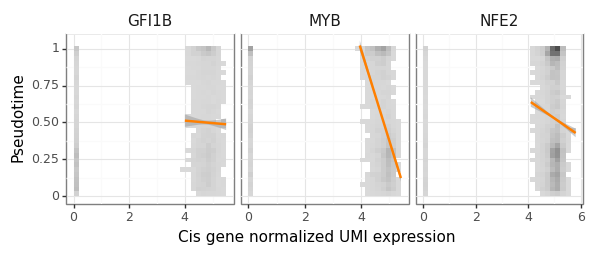

<ggplot: (2969744308062)>

In [65]:
p

In [66]:
plot_df = adata_query.obs[["gene", "dosage_gene_log2FC", "palantir_pseudotime", "short_ID", "cell_line"]]
plot_df = plot_df.groupby(["short_ID", "cell_line"]).mean()
plot_df["gene"] = [x[0] for x in plot_df.index.get_level_values(0).str.split("_")]

/scratch/41867941/ipykernel_22303/197412048.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/home/marii/.local/lib/python3.10/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
/home/marii/.local/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


In [67]:
p = (ggplot(plot_df, aes(y = "palantir_pseudotime", x = "dosage_gene_log2FC")) +
        geom_point(size = 1, alpha = 0.75) +
        geom_smooth(method="loess", alpha = 0.25, size = 0.75, color="#FF7F00") +
        facet_wrap("~ gene", scales = "free_x") +
        theme_bw() +
        xlab("Cis gene log2(FC)") +
        ylab("Mean pseudotime") +
        theme(axis_text=element_text(size = 9), 
              legend_key = element_blank(), 
              strip_background = element_rect(colour="white", fill="white"), 
              axis_title = element_text(size = 11), 
              strip_text = element_text(size = 11), 
              plot_title = element_text(size = 12, face = "bold"),
             figure_size=(6.675, 2.225)))
p.save("../../plots/09-integration/Panel_E.svg", dpi=720, format="svg")

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.675 x 2.225 in image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../../plots/09-integration/Panel_E.svg


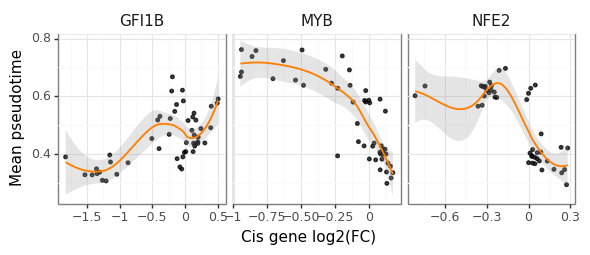

<ggplot: (2969645495675)>

In [68]:
p